In [63]:
import os
import cv2 #biblioteca de prelucrare de imagini
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [64]:
os.environ['TF_DISABLE_MEMORY_OPTIMIZATION']='1'

In [65]:
def load_breakhis_400x_data(train_dir, test_dir):
    label_to_index = {'benign': 0, 'malignant': 1}

    def load_images_from_directory(directory):
        images = []
        labels = []
        for label_name in os.listdir(directory): #parcurg fiecare fisier din directorul meu
            label_index = label_to_index[label_name] #atribui 0 pentru benign si 1 pentru malignant
            label_dir = os.path.join(directory, label_name) #fac un path catre fisierul meu cu poze pentru al accesa
            for image_file in os.listdir(label_dir): #parcurg fiecare imagine
                image_path = os.path.join(label_dir, image_file) #creez path-ul catre imagine
                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224)) #in caz ca nu au toate aceeasi dimensiune le redimensionez la dimensiunea 224x224
                images.append(image) #adaug imaginea in lista
                labels.append(label_index) #adaug indexii in lista
        return np.array(images), np.array(labels)  #returnez o matrice pentru fiecare
    
    x_train, y_train = load_images_from_directory(train_dir) #train: poze pentru antrenare
    x_test, y_test = load_images_from_directory(test_dir) #test: poze noi, le vede prima data
    #normalizare
    x_train = x_train/255.0 #x_train și x_test sunt împărțite la 255.0. 
    #Aceasta transformare se face pentru a scala valorile pixelilor din intervalul [0, 255] în intervalul [0, 1].
    x_test = x_test/255.0
    return x_train, y_train, x_test, y_test

In [66]:
train_directory = "/kaggle/input/breakhis-400x/BreaKHis 400X/train"
test_directory = "/kaggle/input/breakhis-400x/BreaKHis 400X/test"

In [67]:
x_train, y_train, x_test, y_test = load_breakhis_400x_data(train_directory, test_directory)

In [68]:
permutation = np.random.permutation(len(x_train))

In [69]:
x_train_shuffled = x_train[permutation]
y_train_shuffled = y_train[permutation]

In [70]:
#nu o folosesc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   vertical_flip =  True , 
                                   rotation_range=40,
                                   brightness_range = (0.5, 1.5),
                                   horizontal_flip = True)

train_data = train_datagen.flow_from_directory("/kaggle/input/breakhis-400x/BreaKHis 400X/train",
                                                 target_size = (128, 128), #aceeasi dimensiune pt toate imag
                                                 class_mode='sparse', #tipurile de labeluri - indici intregi (util pt pb de clasificare)
                                                 shuffle=True,seed=1)
test_datagen = ImageDataGenerator(rescale = 1/255) 
test_data = test_datagen.flow_from_directory("/kaggle/input/breakhis-400x/BreaKHis 400X/test",
                                                           batch_size=32,
                                                           target_size=(128,128),
                                                           class_mode='sparse',
                                                           shuffle=True,seed=1)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [83]:
model = Sequential([
    Conv2D(32, (3, 3), activation='gelu', input_shape=(224, 224, 3)), #strat concolutional cu 32 de neuroni
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='gelu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='gelu'),
    MaxPooling2D((2, 2)), #extrage valoarea maxima din fereastra glisanta2x2
    Conv2D(256, (3, 3), activation='gelu', input_shape=(224, 224, 3)), 
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='gelu'),
    Dense(2, activation='sigmoid')
])

In [84]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model_weights.keras', 
                             monitor='val_accuracy',   #o rulare in timpul train-ului sa nu am overfitt
                             save_best_only=True,    
                             mode='max') 

In [85]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
history= model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/15
 2/36 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6328 - loss: 0.6933

W0000 00:00:1716318733.193803     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6552 - loss: 0.6522

W0000 00:00:1716318749.604608     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.6565 - loss: 0.6511 - val_accuracy: 0.8257 - val_loss: 0.5633
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7886 - loss: 0.5142 - val_accuracy: 0.7596 - val_loss: 0.5328
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8206 - loss: 0.4362 - val_accuracy: 0.8440 - val_loss: 0.4710
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8079 - loss: 0.4557 - val_accuracy: 0.8330 - val_loss: 0.4642
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8484 - loss: 0.4210 - val_accuracy: 0.8110 - val_loss: 0.4712
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8352 - loss: 0.4273 - val_accuracy: 0.8239 - val_loss: 0.4742
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8459 - loss: 0.4484 - val_accuracy: 0.8330 - val_loss: 0.4992
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8806 - loss: 0.3687 - val_accuracy: 0.8294 - val_loss: 

In [87]:
results = model.evaluate(x_test,  y_test, verbose = 0) 
print('test loss, test acc:', results)

test loss, test acc: [0.4646037220954895, 0.8183486461639404]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


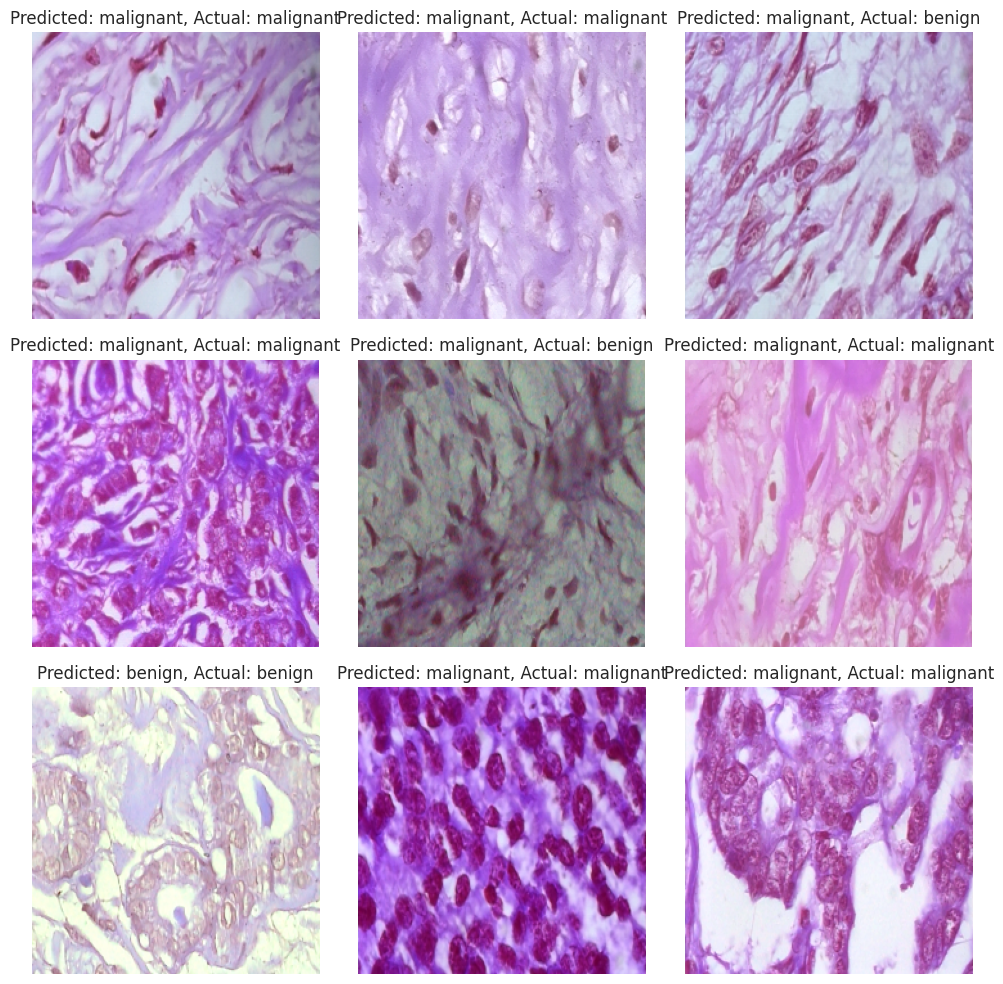

In [88]:
#vizualiez predictia pe 9 imagini random
class_names = ['benign', 'malignant']
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i in range(9):
    index = np.random.randint(0, len(x_test))
    axes[i].imshow(x_test[index])
    prediction = model.predict(x_test[index:index+1])
    predicted_class = np.argmax(prediction)
    axes[i].set_title("Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[y_test[index]]))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [89]:
from sklearn.metrics import classification_report #generez un raport detaliat al performanței clasificatorului
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
#Precizia: Proporția de instanțe prezise ca fiind pozitive care sunt cu adevărat pozitive.
#Recall-ul: Proporția de instanțe pozitive reale care sunt corect identificate.
#F1-Score-ul: Media armonică a preciziei și recall-ului, oferind o măsură echilibrată.
#Suportul: Numărul de instanțe reale pentru fiecare clasă din setul de date de testare.

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

W0000 00:00:1716318812.789038     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

     Class 0       0.84      0.54      0.66       176
     Class 1       0.81      0.95      0.88       369

    accuracy                           0.82       545
   macro avg       0.83      0.75      0.77       545
weighted avg       0.82      0.82      0.81       545



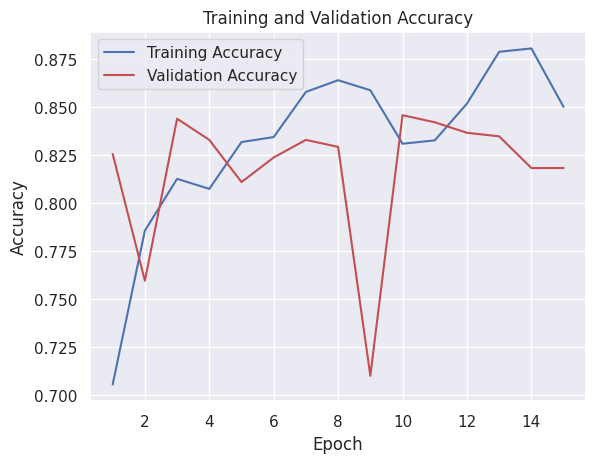

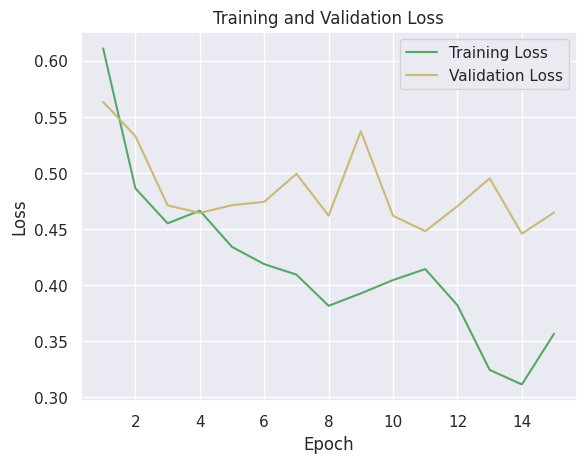

In [90]:
#grafice
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()